In [ ]:
# 查看当前kernel下已安装的包  list packages
!pip list --format=columns

4.6.0
[1324, 1582, 3]


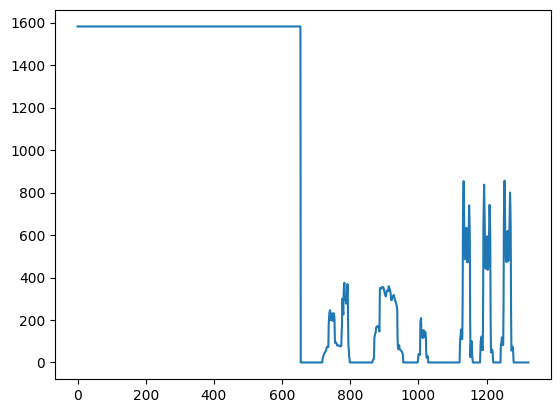

In [161]:
import cv2 as cv
import matplotlib as mpl                  
import matplotlib.pyplot as plt
import numpy as np 

# 图片URl： https://raw.githubusercontent.com/TCDigitalSW/xmu/main/test.png
print(cv.__version__)
img = cv.imread("./test.png")
img2gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
a=np.array(img)
h, w, d = a.shape;
print([h, w, d])

# 计算边缘，然后取横向空白行的行数，以灰度图像所在行所有灰度值的众数作阈值
# 此处存在假设：内容从上往下排列，且不同部位上下间会留有空隙
laplacian = cv.Laplacian(img, cv.CV_64F)
newOne = np.zeros((h, w), dtype = int)
b = np.multiply(np.mean(laplacian, 2), d)
c = np.where(b > 0)
newOne[c] = 1;
sumByRow = np.multiply(np.mean(newOne, 1), w)
sumByCol = np.multiply(np.mean(newOne, 0), h)
rowsWithoutValue = np.array(np.where(sumByRow == 0), dtype = int);
tempImg = img2gray[rowsWithoutValue, :][0];
counts = np.bincount(tempImg.flatten());
throld = np.argmax(counts);

# 二值化，此处为网页截图，不考虑噪声及采样问题，所以采用单阈值而非色彩范围形式
imgThrold = np.zeros((h, w), dtype = int);
imgThrold[np.where(img2gray < throld)] = 1;
sumByRow2 = np.multiply(np.mean(imgThrold, 1), w)
rowsWithoutValue2 = np.array(np.where(sumByRow2 == 0), dtype = int)[0];
rowsWithoutValue2Start = rowsWithoutValue2[1:] - rowsWithoutValue2[:-1] - 1
startIndex = np.array(np.where(rowsWithoutValue2Start != 0))[0];
endIndex = startIndex + 1;
rowEdgeStart = rowsWithoutValue2[startIndex];
rowEdgeEnd = rowsWithoutValue2[endIndex];

plt.plot(sumByRow2) 
plt.show()
# plt.imshow(imgThrold)

In [193]:

pictureEdge = 0
if rowsWithoutValue2[0] != 0:
  pictureEdge = rowsWithoutValue2[0]
# else:
#TODO: 此处可进一步处理兼容首行非图片及图片中存在空白行的场景

print(pictureEdge, rowEdgeStart, rowEdgeEnd)


#以下存在假设：正文字体大小行高固定，且误差不超过2px
lineHeight1 = rowEdgeStart[1:] - rowEdgeStart[:-1];
lineHeight2 = rowEdgeEnd[1:] - rowEdgeEnd[:-1];
fontSize = rowEdgeEnd - rowEdgeStart;
uniqueFontSize = np.unique(fontSize);
counter = np.zeros(uniqueFontSize.size, dtype=int)
for i in range(uniqueFontSize.size):
    for j in range(fontSize.size):
        if fontSize[j] >= uniqueFontSize[i] - 2 and  fontSize[j] <= uniqueFontSize[i] + 2:
            counter[i] += 1
            
selectFontSize = uniqueFontSize[np.where(counter == np.amax(counter))][0];
intersectId = np.intersect1d(np.where(fontSize <= selectFontSize + 2), np.where(fontSize >= selectFontSize - 2))
contentEdges = np.sort(np.array([rowEdgeStart[intersectId], rowEdgeEnd[intersectId]]).flatten())
contentEdges = contentEdges[[0, -1]]

contentTopEdge = contentEdges[0]
contentBottomEdge = contentEdges[1]


print(contentEdges)

655 [ 718  865  998 1121 1181 1241] [ 799  956 1029 1160 1220 1280]
[1121 1280]


[107, 1453]


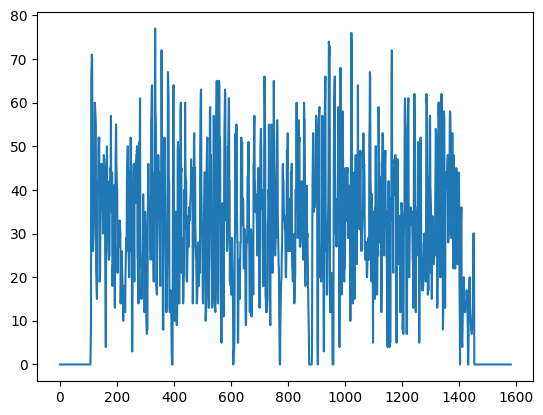

In [201]:

contetnImgThrold = imgThrold[contentTopEdge:contentBottomEdge, :];
contentH, contentW = np.shape(contetnImgThrold);
sumByCol3 = np.multiply(np.mean(contetnImgThrold, 0), contentH)

contentLeftEdge = 0
contentRightEdge = w - 1;

for i in range(w):
    if sumByCol3[i] == 0:
        contentLeftEdge = i
    else:
        break
for i in range(w):
    if sumByCol3[w - i - 1] == 0:
        contentRightEdge = w - i - 1
    else:
        break

print([contentLeftEdge, contentRightEdge])
plt.plot(sumByCol3) 

655 [1121, 1280] [107, 1453]


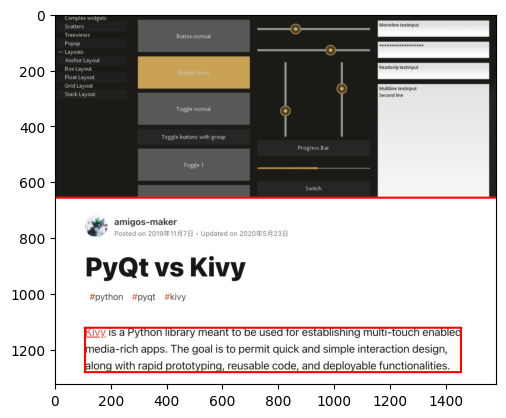

In [205]:
print(pictureEdge, [contentTopEdge, contentBottomEdge], [contentLeftEdge, contentRightEdge])
# x = range(w);
y1 = np.ones(w)*pictureEdge;

x1 = np.arange(contentLeftEdge, contentRightEdge)
y2 = np.ones(contentRightEdge-contentLeftEdge)*contentTopEdge;
y3 = np.ones(contentRightEdge-contentLeftEdge)*contentBottomEdge;

y4 = np.arange(contentTopEdge, contentBottomEdge)
x2 = np.ones(contentBottomEdge-contentTopEdge)*contentLeftEdge;
x3 = np.ones(contentBottomEdge-contentTopEdge)*contentRightEdge;

plt.imshow(img)
plt.plot(y1, 'r')
plt.plot(x1, y2, 'r')
plt.plot(x1, y3, 'r')
plt.plot(x2, y4, 'r')
plt.plot(x3, y4, 'r')